🚀 CONTEXTUAL BANDIT ANALYSIS WITH TRAIN/TEST SPLIT
Loading dataset from 'customer_data.xlsx'...
✅ Loaded 10000 samples with 9 context features.
🎯 Found 7 unique actions (discounts).

Pre-processing context features (Standard Scaling + Intercept)...
Processed context dimension: 10

Splitting data into 80% training and 20% testing sets...
Training set size: 8000
Test set size:     2000

[PHASE 1] Training LinUCB model on the training data...
✅ LinUCB training complete.

[PHASE 2] Evaluating models on the unseen test data...
✅ Evaluation complete.

PERFORMANCE SUMMARY ON TEST DATA
Total Cumulative Reward on Test Set:
  LinUCB (Pre-Trained):       $100,110.00
  ε-Greedy (Cold Start):      $83,030.00
  Improvement:                +20.6%
  Dollar Gain:                $17,080.00

Discount Strategy Analysis on Test Set:
----------------------------------------
LinUCB Discount Preferences:
    0% discount:  1473 times (73.7%)
    5% discount:    85 times ( 4.2%)
   10% discount:    34 times ( 1

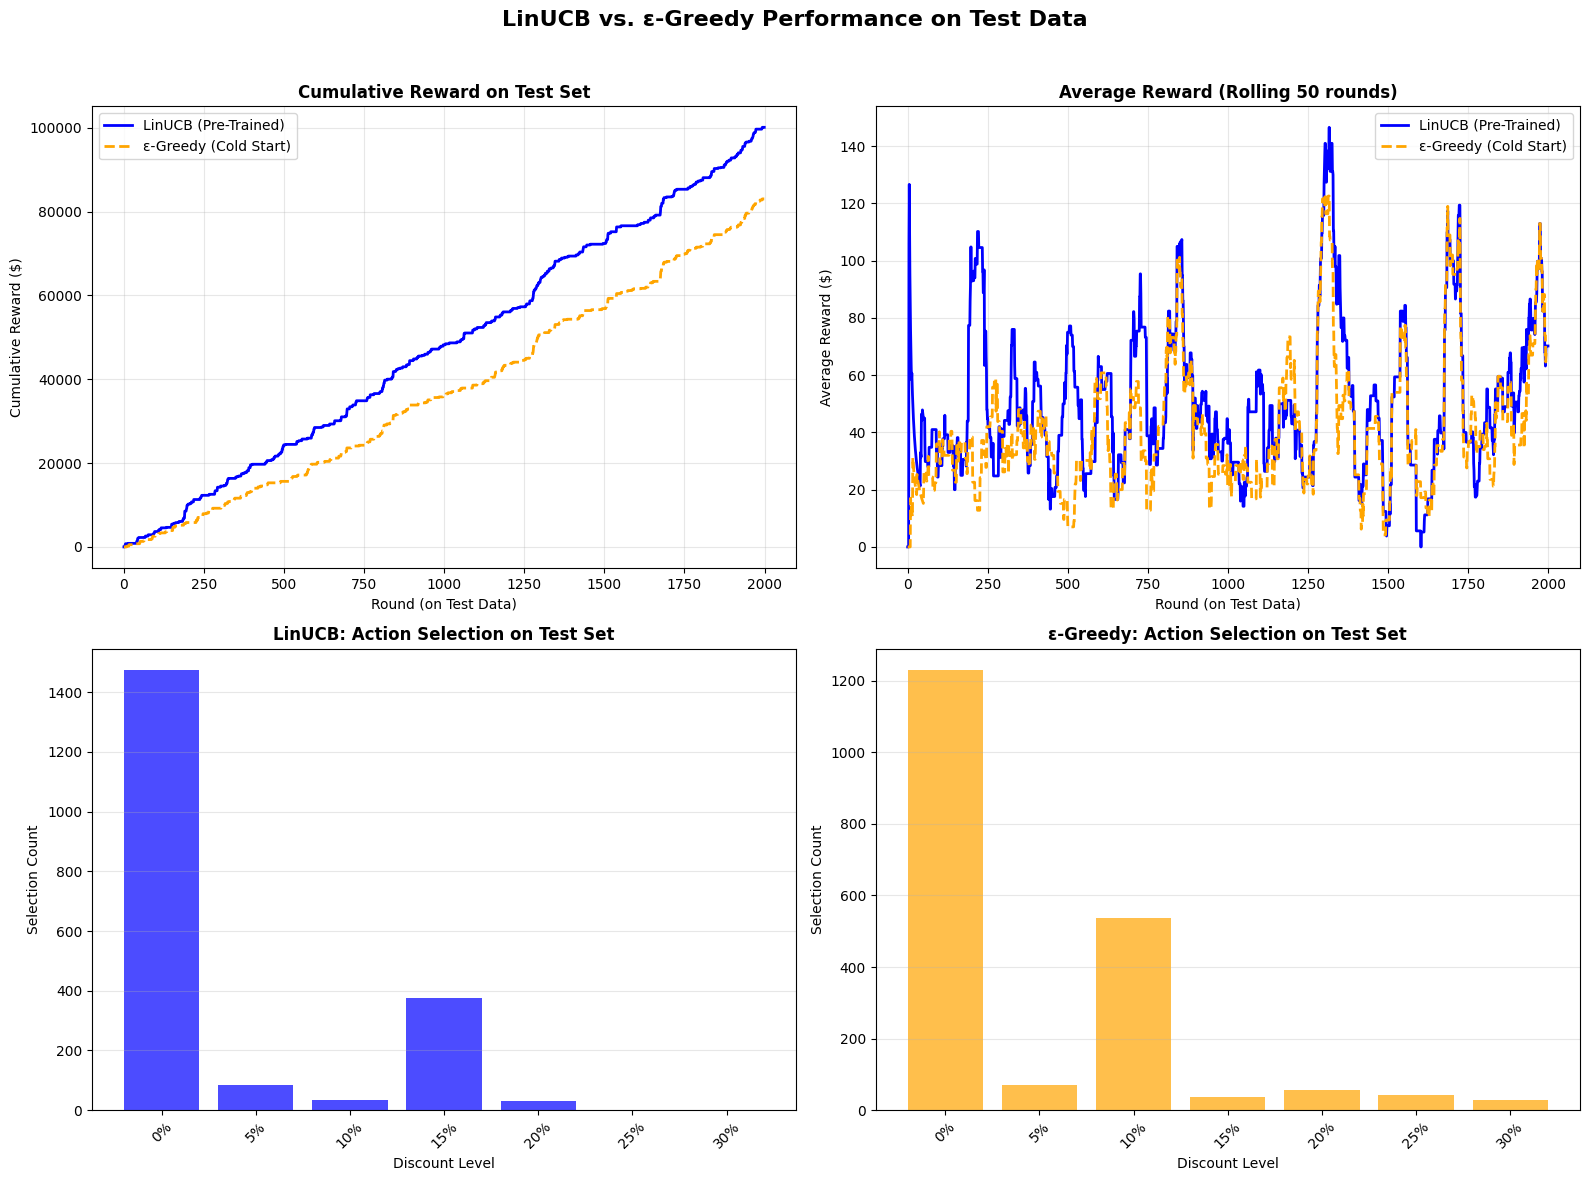

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from typing import List
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(1042)

class LinUCB:
    """Linear Upper Confidence Bound algorithm"""
    
    def __init__(self, context_dim: int, n_actions: int, alpha: float = 2.0):
        self.context_dim = context_dim
        self.n_actions = n_actions
        self.alpha = alpha
        
        # Initialize parameters for each action
        self.A = [np.identity(context_dim) for _ in range(n_actions)]
        self.b = [np.zeros(context_dim) for _ in range(n_actions)]
        self.theta = [np.zeros(context_dim) for _ in range(n_actions)]
        
        # Track performance during evaluation
        self.rewards_history = []
        self.actions_history = []
        
    def select_action(self, context: np.ndarray) -> int:
        """Select action using LinUCB policy"""
        ucb_values = []
        
        for a in range(self.n_actions):
            try:
                # Update theta before calculating UCB
                A_inv = np.linalg.inv(self.A[a])
                self.theta[a] = A_inv @ self.b[a]
                
                mean_reward = context @ self.theta[a]
                confidence_width = self.alpha * np.sqrt(context @ A_inv @ context)
                ucb = mean_reward + confidence_width
                
                ucb_values.append(ucb)
            except np.linalg.LinAlgError:
                ucb_values.append(float('inf'))
        
        return np.argmax(ucb_values)
    
    def update(self, context: np.ndarray, action: int, reward: float):
        """Update model parameters"""
        self.A[action] += np.outer(context, context)
        self.b[action] += reward * context
    
    def get_cumulative_reward(self) -> List[float]:
        """Get cumulative reward over time"""
        return np.cumsum(self.rewards_history).tolist()

class EpsilonGreedy:
    """Enhanced Epsilon-Greedy with decaying exploration"""
    
    def __init__(self, context_dim: int, n_actions: int, epsilon: float = 0.2):
        self.context_dim = context_dim
        self.n_actions = n_actions
        self.initial_epsilon = epsilon
        self.epsilon = epsilon
        
        # Track average rewards for each action
        self.action_rewards = [[] for _ in range(n_actions)]
        self.action_counts = [0] * n_actions
        
        # Track performance
        self.rewards_history = []
        self.actions_history = []
        self.t = 0
        
    def select_action(self, context: np.ndarray = None) -> int:
        """Select action using epsilon-greedy policy with decay"""
        self.t += 1
        self.epsilon = self.initial_epsilon / (1 + self.t / 1000)
        
        if np.random.random() < self.epsilon:
            return np.random.randint(0, self.n_actions)
        else:
            if all(count == 0 for count in self.action_counts):
                return np.random.randint(0, self.n_actions)
            
            avg_rewards = [np.mean(self.action_rewards[a]) if self.action_counts[a] > 0 else -float('inf') for a in range(self.n_actions)]
            return np.argmax(avg_rewards)
    
    def update(self, context: np.ndarray, action: int, reward: float):
        """Update action value estimates"""
        self.action_rewards[action].append(reward)
        self.action_counts[action] += 1
    
    def get_cumulative_reward(self) -> List[float]:
        """Get cumulative reward over time"""
        return np.cumsum(self.rewards_history).tolist()

# Train LinUCB Model
def train_linucb(linucb_model: LinUCB, train_contexts: np.ndarray, train_actions: np.ndarray, train_rewards: np.ndarray):
    """
    Trains the LinUCB model on the training dataset.
    This function directly updates the model's parameters using the historical data,
    simulating the learning process without making new action choices.
    """
    n_rounds = len(train_contexts)
    for t in range(n_rounds):
        context = train_contexts[t]
        action = train_actions[t]
        reward = train_rewards[t]
        linucb_model.update(context, action, reward)
    return linucb_model

# Evaluate Models
def evaluate_models(trained_linucb: LinUCB, test_contexts: np.ndarray, test_actions: np.ndarray, test_rewards: np.ndarray):
    """
    Evaluates a pre-trained LinUCB model and a fresh Epsilon-Greedy model on the test data.
    """
    context_dim = test_contexts.shape[1]
    n_actions = trained_linucb.n_actions
    
    # Initialize a new Epsilon-Greedy model to compare against
    eps_greedy = EpsilonGreedy(context_dim, n_actions, epsilon=0.2)
    
    n_rounds = len(test_contexts)

    for t in range(n_rounds):
        context = test_contexts[t]
        h_action = test_actions[t]
        h_reward = test_rewards[t]

        # --- LinUCB (pre-trained) ---
        chosen_action_linucb = trained_linucb.select_action(context)
        trained_linucb.actions_history.append(chosen_action_linucb)
        
        # Off-policy update: only update if the agent's action matches the historical action
        if chosen_action_linucb == h_action:
            # We can optionally continue to update LinUCB on the test data as well
            trained_linucb.update(context, chosen_action_linucb, h_reward)
            trained_linucb.rewards_history.append(h_reward)
        else:
            trained_linucb.rewards_history.append(0)

        # --- Epsilon-Greedy (learning from scratch) ---
        chosen_action_eps = eps_greedy.select_action(context)
        eps_greedy.actions_history.append(chosen_action_eps)
        
        if chosen_action_eps == h_action:
            eps_greedy.update(context, chosen_action_eps, h_reward)
            eps_greedy.rewards_history.append(h_reward)
        else:
            eps_greedy.rewards_history.append(0)
            
    return trained_linucb, eps_greedy

def plot_results(linucb: LinUCB, eps_greedy: EpsilonGreedy, n_actions: int):
    """Plot comprehensive comparison results. No changes needed here."""
    
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle('LinUCB vs. ε-Greedy Performance on Test Data', fontsize=16, fontweight='bold')
    
    # Plot 1: Cumulative Reward
    axes[0, 0].plot(linucb.get_cumulative_reward(), label='LinUCB (Pre-Trained)', linewidth=2, color='blue')
    axes[0, 0].plot(eps_greedy.get_cumulative_reward(), label='ε-Greedy (Cold Start)', linewidth=2, color='orange', linestyle='--')
    axes[0, 0].set_title('Cumulative Reward on Test Set', fontsize=12, fontweight='bold')
    axes[0, 0].set_xlabel('Round (on Test Data)')
    axes[0, 0].set_ylabel('Cumulative Reward ($)')
    axes[0, 0].legend()
    axes[0, 0].grid(False, alpha=0.3)
    
    # Plot 2: Average Reward (Rolling Window)
    window_size = 50 # Reduced window for smaller test set
    linucb_rolling = pd.Series(linucb.rewards_history).rolling(window_size, min_periods=1).mean()
    eps_rolling = pd.Series(eps_greedy.rewards_history).rolling(window_size, min_periods=1).mean()
    
    axes[0, 1].plot(linucb_rolling, label='LinUCB (Pre-Trained)', linewidth=2, color='blue')
    axes[0, 1].plot(eps_rolling, label='ε-Greedy (Cold Start)', linewidth=2, color='orange', linestyle='--')
    axes[0, 1].set_title(f'Average Reward (Rolling {window_size} rounds)', fontsize=12, fontweight='bold')
    axes[0, 1].set_xlabel('Round (on Test Data)')
    axes[0, 1].set_ylabel('Average Reward ($)')
    axes[0, 1].legend()
    axes[0, 1].grid(False, alpha=0.3)
    
    # Define labels based on the fixed number of actions
    discount_labels = [f'{i*5}%' for i in range(n_actions)]
    
    # Plot 3: Action Distribution for LinUCB
    action_counts_linucb = np.bincount(linucb.actions_history, minlength=n_actions)
    axes[1, 0].bar(range(n_actions), action_counts_linucb, alpha=0.7, color='blue')
    axes[1, 0].set_title('LinUCB: Action Selection on Test Set', fontsize=12, fontweight='bold')
    axes[1, 0].set_xlabel('Discount Level')
    axes[1, 0].set_ylabel('Selection Count')
    axes[1, 0].set_xticks(range(n_actions))
    axes[1, 0].set_xticklabels(discount_labels, rotation=45)
    axes[1, 0].grid(False, axis='y', alpha=0.3)
    
    # Plot 4: Action Distribution for Epsilon-Greedy
    action_counts_eps = np.bincount(eps_greedy.actions_history, minlength=n_actions)
    axes[1, 1].bar(range(n_actions), action_counts_eps, alpha=0.7, color='orange')
    axes[1, 1].set_title('ε-Greedy: Action Selection on Test Set', fontsize=12, fontweight='bold')
    axes[1, 1].set_xlabel('Discount Level')
    axes[1, 1].set_ylabel('Selection Count')
    axes[1, 1].set_xticks(range(n_actions))
    axes[1, 1].set_xticklabels(discount_labels, rotation=45)
    axes[1, 1].grid(False, axis='y', alpha=0.3)
    
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

def print_performance_summary(linucb: LinUCB, eps_greedy: EpsilonGreedy, n_actions: int):
    """Print detailed performance summary. No changes needed here."""
    
    print("="*80)
    print("PERFORMANCE SUMMARY ON TEST DATA")
    print("="*80)
    
    total_linucb = sum(linucb.rewards_history)
    total_eps = sum(eps_greedy.rewards_history)
    
    if total_eps > 0:
        improvement = (total_linucb - total_eps) / total_eps * 100
        print(f"Total Cumulative Reward on Test Set:")
        print(f"  LinUCB (Pre-Trained):       ${total_linucb:,.2f}")
        print(f"  ε-Greedy (Cold Start):      ${total_eps:,.2f}")
        print(f"  Improvement:                {improvement:+.1f}%")
        print(f"  Dollar Gain:                ${total_linucb - total_eps:,.2f}")
    else:
        print("Epsilon-Greedy earned no reward, improvement cannot be calculated.")
        print(f"  LinUCB Total Reward:   ${total_linucb:,.2f}")

    print()
    
    discount_levels = [f'{i*5}%' for i in range(n_actions)]
    
    print("Discount Strategy Analysis on Test Set:")
    print("-" * 40)
    print("LinUCB Discount Preferences:")
    action_counts_linucb = np.bincount(linucb.actions_history, minlength=n_actions)
    for i, (discount, count) in enumerate(zip(discount_levels, action_counts_linucb)):
        pct = count / len(linucb.actions_history) * 100 if len(linucb.actions_history) > 0 else 0
        print(f"  {discount:>4} discount: {count:5d} times ({pct:4.1f}%)")
    
    print("\nε-Greedy Discount Preferences:")
    action_counts_eps = np.bincount(eps_greedy.actions_history, minlength=n_actions)
    for i, (discount, count) in enumerate(zip(discount_levels, action_counts_eps)):
        pct = count / len(eps_greedy.actions_history) * 100 if len(eps_greedy.actions_history) > 0 else 0
        print(f"  {discount:>4} discount: {count:5d} times ({pct:4.1f}%)")

# ### MODIFIED MAIN FUNCTION ###
def main():
    """Main execution function with train/test split"""
    
    print("🚀 CONTEXTUAL BANDIT ANALYSIS WITH TRAIN/TEST SPLIT")
    print("="*80)
    
    try:
        print("Loading dataset from 'customer_data.xlsx'...")
        customer_data = pd.read_excel('customer_data.xlsx')
    except FileNotFoundError:
        print("\nERROR: 'customer_data.xlsx' not found.")
        print("Please make sure the Excel file is in the same directory as the script.")
        return

    context_columns = [col for col in customer_data.columns if col not in ['action', 'reward']]
    
    contexts = customer_data[context_columns].values
    actions = customer_data['action'].values
    rewards = customer_data['reward'].values
    n_actions = len(np.unique(actions))

    print(f"✅ Loaded {len(contexts)} samples with {contexts.shape[1]} context features.")
    print(f"🎯 Found {n_actions} unique actions (discounts).")
    
    print("\nPre-processing context features (Standard Scaling + Intercept)...")
    scaler = StandardScaler()
    contexts_scaled = scaler.fit_transform(contexts)
    processed_contexts = np.c_[contexts_scaled, np.ones(contexts_scaled.shape[0])]
    context_dim = processed_contexts.shape[1]
    print(f"Processed context dimension: {context_dim}")
    
    print("\nSplitting data into 80% training and 20% testing sets...")
    X_train, X_test, y_actions_train, y_actions_test, y_rewards_train, y_rewards_test = train_test_split(
        processed_contexts, actions, rewards, test_size=0.2, random_state=42, stratify=actions
    )
    print(f"Training set size: {len(X_train)}")
    print(f"Test set size:     {len(X_test)}")
    
    print("\n[PHASE 1] Training LinUCB model on the training data...")
    linucb_model = LinUCB(context_dim, n_actions, alpha=2.0)
    trained_linucb = train_linucb(linucb_model, X_train, y_actions_train, y_rewards_train)
    print("✅ LinUCB training complete.")
    
    print("\n[PHASE 2] Evaluating models on the unseen test data...")
    linucb_results, eps_greedy_results = evaluate_models(
        trained_linucb, X_test, y_actions_test, y_rewards_test
    )
    print("✅ Evaluation complete.")
    print()

    # Print and plot the results from the evaluation phase
    print_performance_summary(linucb_results, eps_greedy_results, n_actions)
    plot_results(linucb_results, eps_greedy_results, n_actions)
    
if __name__ == "__main__":
    main()